In [1]:
# !pip install torch
# !pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [22]:
# VAE Architecture 
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x_flat = x.view(-1, self.input_dim)
        h1 = torch.relu(self.fc1(x_flat))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        mu, logvar = self.encode(x_flat)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
# Convolutional VAE Architecture (for CIFAR-10: 3x32x32 images)
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128, in_channels=3):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder: 32 -> 16 -> 8 -> 4 -> 2
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1),   # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),            # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),           # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),          # 4x4 -> 2x2
            nn.ReLU(),
        )
        self.enc_fc = nn.Linear(256 * 2 * 2, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 4, 2, 1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        h = torch.relu(self.enc_fc(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.dec_fc(z))
        h = h.view(h.size(0), 256, 2, 2)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
# Loss function (works for both FC and Conv VAE: flattens recon and x for BCE)
def loss_function(recon_x, x, mu, logvar):
    recon_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    BCE = nn.functional.binary_cross_entropy(recon_flat, x_flat, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [6]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [7]:
# Load MNIST dataset and run the training
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=784, hidden_dim=400, latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.35MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 642kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.08MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 163.6300580403646
Epoch 2, Loss: 121.81779562174479
Epoch 3, Loss: 114.66346376953125
Epoch 4, Loss: 111.53956474609375
Epoch 5, Loss: 109.67821925455729
Epoch 6, Loss: 108.48114477539062
Epoch 7, Loss: 107.64353178710938
Epoch 8, Loss: 106.99072042643229
Epoch 9, Loss: 106.49374978841146
Epoch 10, Loss: 106.10132864583333


## Task 1: Convolutional VAE on CIFAR-10

In [8]:
# Load CIFAR-10 and train fully connected VAE (for comparison with ConvVAE)
CIFAR_TRANSFORM = transforms.ToTensor()
cifar_train = datasets.CIFAR10('./data', train=True, download=True, transform=CIFAR_TRANSFORM)
cifar_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)

# Fully connected VAE for CIFAR-10: 32*32*3 = 3072 input dimension
vae_fc_cifar = VAE(input_dim=3072, hidden_dim=400, latent_dim=128)
optimizer_fc = optim.Adam(vae_fc_cifar.parameters(), lr=1e-3)

print("Training FC VAE on CIFAR-10...")
for epoch in range(1, 11):
    train(vae_fc_cifar, cifar_loader, optimizer_fc, epoch)

100%|██████████| 170M/170M [00:52<00:00, 3.26MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Training FC VAE on CIFAR-10...
Epoch 1, Loss: 1987.5045096875
Epoch 2, Loss: 1912.4181284375
Epoch 3, Loss: 1890.63944875
Epoch 4, Loss: 1878.99963875
Epoch 5, Loss: 1870.670228125
Epoch 6, Loss: 1867.5467915625
Epoch 7, Loss: 1865.3811415625
Epoch 8, Loss: 1863.532990625
Epoch 9, Loss: 1861.2346459375
Epoch 10, Loss: 1859.61122125


In [9]:
# convolutional VAE on CIFAR-10
conv_vae = ConvVAE(latent_dim=128, in_channels=3)
optimizer_conv = optim.Adam(conv_vae.parameters(), lr=1e-3)

print("Training ConvVAE on CIFAR-10...")
for epoch in range(1, 11):
    train(conv_vae, cifar_loader, optimizer_conv, epoch)

Training ConvVAE on CIFAR-10...
Epoch 1, Loss: 1993.0737225
Epoch 2, Loss: 1921.14880375
Epoch 3, Loss: 1896.673721875
Epoch 4, Loss: 1881.859565
Epoch 5, Loss: 1870.3675
Epoch 6, Loss: 1864.583250625
Epoch 7, Loss: 1860.4823771875
Epoch 8, Loss: 1857.950874375
Epoch 9, Loss: 1855.1673290625
Epoch 10, Loss: 1853.769566875


In [10]:
def generate_images_cifar(model, num_images=8, latent_dim=128, is_conv=True):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim)
        generated = model.decode(z).cpu()
    if is_conv:
        generated = generated.permute(0, 2, 3, 1)
    else:
        generated = generated.view(num_images, 3, 32, 32).permute(0, 2, 3, 1)
    return generated.clamp(0, 1).numpy()

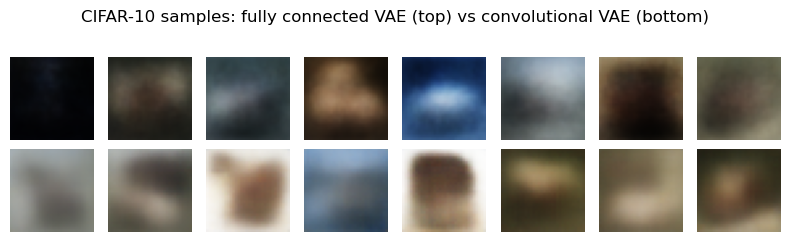

In [13]:
# compare generated images
import matplotlib.pyplot as plt

num_show = 8
fig, axes = plt.subplots(2, num_show, figsize=(num_show, 2.5))

fc_images = generate_images_cifar(vae_fc_cifar, num_images=num_show, latent_dim=128, is_conv=False)
conv_images = generate_images_cifar(conv_vae, num_images=num_show, latent_dim=128, is_conv=True)

for i in range(num_show):
    axes[0, i].imshow(fc_images[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(conv_images[i])
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('FC VAE', fontsize=11)
axes[1, 0].set_ylabel('ConvVAE', fontsize=11)
plt.suptitle('CIFAR-10 samples: fully connected VAE (top) vs convolutional VAE (bottom)', fontsize=12)
plt.tight_layout()
plt.show()

### Question 1 Comparison

In general, the two rows of images aren't spectacularly diffent, however, we can see that the bottom row corresponding to the convolutional VAE is slightly clearer and more coherent than the fully connected VAE (not by much!). Because the convolutional VAE perserves spatial structure via convolutional layers, the local patterns and edges are learned more effectively while the fully connected VAE flattens the image to a vector and loses the spatial relationships.



## Task 2: Latent space interpolation

In [20]:
def interpolate_latent(model, img1, img2, num_steps=10):
    model.eval()
    if img1.dim() == 3:
        img1, img2 = img1.unsqueeze(0), img2.unsqueeze(0)
    with torch.no_grad():
        mu1, _ = model.encode(img1)
        mu2, _ = model.encode(img2)
        # Linear interpolation in latent space
        alphas = torch.linspace(0, 1, num_steps + 2)
        images = []
        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            out = model.decode(z)
            images.append(out.cpu())
        return images

In [23]:
# pick two images of diff digits
num_steps = 10
digits_a, digits_b = 3, 8  # change to any pair 0-9
train_data = train_loader.dataset
idx_a = next(i for i, (_, y) in enumerate(train_data) if y == digits_a)
idx_b = next(i for i, (_, y) in enumerate(train_data) if y == digits_b)
img_a = train_data[idx_a][0].unsqueeze(0)   # (1, 1, 28, 28)
img_b = train_data[idx_b][0].unsqueeze(0)

interp_list = interpolate_latent(vae, img_a, img_b, num_steps=num_steps)
n = len(interp_list)
fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
for i, recon in enumerate(interp_list):
    axes[i].imshow(recon[0].view(28, 28).numpy(), cmap='gray')
    axes[i].axis('off')
plt.suptitle(f'MNIST VAE: latent interpolation (digit {digits_a} → {digits_b})', fontsize=11)
plt.tight_layout()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (28x28 and 784x400)

In [ ]:
# interpolation with ConvVAE on CIFAR-10 & pick two images from the training set
cifar_iter = iter(cifar_loader)
cbatch1, _ = next(cifar_iter)
cbatch2, _ = next(cifar_iter)
cifar_a = cbatch1[0:1]   # (1, 3, 32, 32)
cifar_b = cbatch2[0:1]

interp_cifar = interpolate_latent(conv_vae, cifar_a, cifar_b, num_steps=num_steps)
n = len(interp_cifar)
fig, axes = plt.subplots(1, n, figsize=(n, 1.4))
for i, recon in enumerate(interp_cifar):
    # (1, 3, 32, 32) -> (32, 32, 3) for imshow
    im = recon[0].permute(1, 2, 0).clamp(0, 1).numpy()
    axes[i].imshow(im)
    axes[i].axis('off')
plt.suptitle('ConvVAE (CIFAR-10): latent interpolation between two images', fontsize=11)
plt.tight_layout()
plt.show()

In [14]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')
        axs[i].axis('off')
    plt.show()




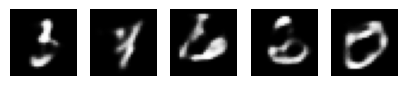

In [15]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 20
generate_images(vae, num_images=5, latent_dim=20)